In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darshviradiya","key":"e108c44bf942cd3149721291156da190"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 946MB/s]


In [5]:
!unzip sentiment-analysis-on-movie-reviews.zip

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [6]:
!unzip train.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               


In [7]:
!unzip test.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                


In [8]:
test=pd.read_csv('test.tsv',sep='\t')
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66291 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [10]:
df=pd.read_csv('train.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [11]:
df.shape

(156060, 4)

In [12]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [13]:
sentences=df['Phrase']
y=df['Sentiment']

In [14]:
pd.set_option('display.max_colwidth', None)
sentences.head(15)

,Phrase
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story ."
1,A series of escapades demonstrating the adage that what is good for the goose
2,A series
3,A
4,series
5,of escapades demonstrating the adage that what is good for the goose
6,of
7,escapades demonstrating the adage that what is good for the goose
8,escapades
9,demonstrating the adage that what is good for the goose


In [15]:
df['Sentiment'].value_counts()

,count
Sentiment,
2,79582
3,32927
1,27273
4,9206
0,7072


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense,GRU,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
max_len=[x for x in sentences.str.split().str.len()]
max(max_len)

52

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
phrases_train, phrases_val, y_train, y_val = train_test_split(
    df['Phrase'],
    df['Sentiment'],
    test_size=0.2,      # Use 20% of the data for validation
    random_state=42,    # Set a random state for reproducibility
    stratify=df['Sentiment'] # Stratify to maintain class distribution in train/val splits
)

In [28]:
phrases_test=test['Phrase']

In [31]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(phrases_train)

phrases_test = phrases_test.fillna('')

sent_train=pad_sequences(tokenizer.texts_to_sequences(phrases_train),maxlen=53,padding='post')
sent_val=pad_sequences(tokenizer.texts_to_sequences(phrases_val),maxlen=53,padding='post')
sent_test=pad_sequences(tokenizer.texts_to_sequences(phrases_test),maxlen=53,padding='post')

In [32]:
sent_train.shape

(124848, 53)

In [33]:
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200, input_length=53))
model1.add(GRU(units=128, return_sequences=True))
model1.add(Dropout(0.3))
model1.add(Bidirectional(GRU(units=64, return_sequences=True)))
model1.add(Dropout(0.3))
model1.add(Bidirectional(GRU(units=64)))
model1.add(Dropout(0.3))
model1.add(Dense(units=5, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [37]:
history=model1.fit(sent_train, y_train, epochs=5, batch_size=128, validation_data=(sent_val, y_val), callbacks=[early_stopping])

Epoch 1/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5680 - loss: 1.0851 - val_accuracy: 0.6558 - val_loss: 0.8359
Epoch 2/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.6835 - loss: 0.7724 - val_accuracy: 0.6701 - val_loss: 0.8072
Epoch 3/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.7131 - loss: 0.6885 - val_accuracy: 0.6640 - val_loss: 0.8192
Epoch 4/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7335 - loss: 0.6384 - val_accuracy: 0.6742 - val_loss: 0.8229
Epoch 5/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7523 - loss: 0.5940 - val_accuracy: 0.6695 - val_loss: 0.8327


In [38]:
y_pred_val_prob=model1.predict(sent_val)
y_pred_val=np.argmax(y_pred_val_prob,axis=1)

976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [39]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
accuracy_val=accuracy_score(y_val,y_pred_val)
f1_val=f1_score(y_val,y_pred_val,average='weighted')

print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Validation F1 Score (Weighted): {f1_val:.4f}')

Validation Accuracy: 0.6701
Validation F1 Score (Weighted): 0.6617


In [41]:
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
print(conf_matrix_val)

[[  353   931   121     8     1]
 [  213  3170  1940   126     6]
 [   38  1524 13054  1241    60]
 [    5   200  2272  3419   689]
 [    2    18   103   799   919]]


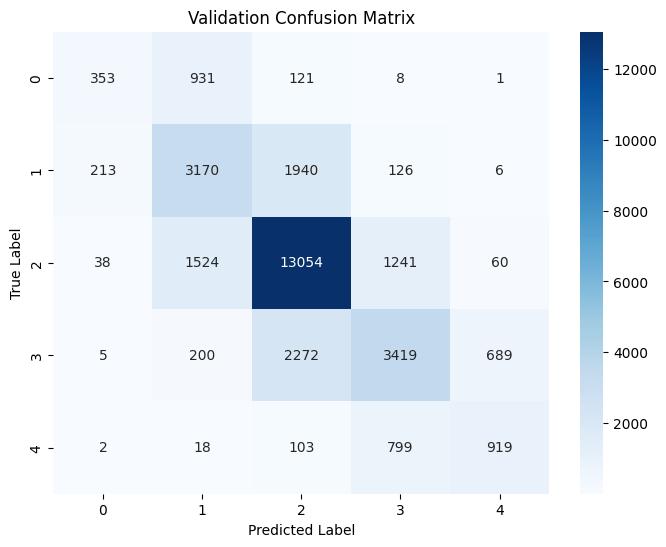

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Confusion Matrix')
plt.show()

In [43]:
import re
import string

def clean_text(text):
    """
    Cleans a review by:
    - Lowercasing
    - Removing punctuation (! ? . , etc.)
    - Stripping extra spaces
    """
    # Lowercase the text
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Optional: Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [44]:
text="Good movie and plot was good but character developing could be better"
text=clean_text(text)
processed_text=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=53,padding='post',truncating='post')

y_pred_prob=model1.predict(processed_text)
y_pred=np.argmax(y_pred_prob,axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([2])